### a) Imports

In [78]:
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
import os
import simplejson
import sys
import numpy as np
from sklearn.datasets import load_svmlight_file
import dsdl #https://github.com/fkunstner/dataset-downloader.git

import loss_functions, make_plots
import scr, tr, sgd, saga, ns, sn
from sketches import gaussian, srht, less, sparse_rademacher, rrs, sjlt, lvrg_sampling, sqrn_sampling, lev_approx

from loss_functions import phi
from functools import partial

### b) load data and initialize weights

In [79]:
#####################
#### Load  Data  ####
#####################

dataset_name= 'a9a'
# dataset_name = 'random'
expr_lvrg = False # whether to generate sythetic dataset to test leverage score performance
convex = False

#logistic regression:
if expr_lvrg:
    n = 10000
    d = 200
    row, col = np.indices((d, d))

    @np.vectorize
    def sigma_val(i, j, rho=0.9):
      return 2 * rho ** np.abs(i - j)
    # Sigma = sigma_val(row, col)

    X0 = np.random.multivariate_normal(np.zeros(d), sigma_val(row, col, rho=0.6), size=n)
    X1 = np.random.multivariate_normal(np.ones(d), sigma_val(row, col, rho=0.9), size=n)
    X2 = np.random.multivariate_normal(-np.ones(d), sigma_val(row, col, rho=0.9), size=n)
    X = 0.33 * X0 + 0.33 * X1 + 0.33 * X2
    wtrue = 1 + np.random.rand(d)
    Y = np.rint(phi(X.dot(wtrue)))
    d = X.shape[1]
    n = X.shape[0]
    w = np.zeros(d)

if dataset_name=='a9a':
    X, Y = load_svmlight_file('data/a9a')
    X = X.toarray()
    Y= [0 if e == -1 else e for e in Y]
    Y=np.array(Y)      
    d = X.shape[1]
    n = X.shape[0]
    w = np.zeros(d)

if dataset_name=='a9a' and expr_lvrg:
    X, Y = load_svmlight_file('data/a9a')
    X = X.toarray()
    Y= [0 if e == -1 else e for e in Y]
    Y=np.array(Y)
    # lev_scores = lev_approx(X)
    lev_scores = np.linalg.norm(X, axis=1) ** 2
    idx_large = (lev_scores > np.percentile(lev_scores, 75))
    idx_small = (lev_scores < np.percentile(lev_scores, 30))
    X_large = np.compress(idx_large, X, axis=0)
    Y_large = np.compress(idx_large, Y, axis=0)
    # int((X.shape[0] - sum(idx_small))/ sum(idx_small)) + 1
    X_small = np.repeat(np.compress(idx_small, X, axis=0), 2, axis=0)
    Y_small = np.repeat(np.compress(idx_small, Y, axis=0), 2, axis=0)
    # X_small = np.compress(idx_small, X, axis=0)
    # Y_small = np.compress(idx_small, Y, axis=0)
    X = np.concatenate((X_large, X_small), axis=0)
    Y = np.concatenate((Y_large, Y_small), axis=0)
    d = X.shape[1]
    n = X.shape[0]
    w = np.zeros(d)
    print(n)

if dataset_name=='w8a':
    ds = dsdl.load("w8a")
    X, Y = ds.get_train()
    X = X.toarray()
    Y= [0 if e == -1 else e for e in Y]
    Y=np.array(Y)      
    d = X.shape[1]
    n = X.shape[0]
    w = np.zeros(d)
    
#multinominal (softmax) regression:
elif dataset_name == 'mnist':
    import scipy 
    X, Y = load_svmlight_file('data/mnist')
    X = X.toarray()
    nC = len(np.unique(Y))    
    ## one-hot encoding of labels
    data   = np.ones(len(Y))
    indptr = np.arange(len(Y)+1)
    ground_truth = scipy.sparse.csr_matrix((data, Y, indptr))
    Y = ground_truth.todense() #gives a matrix with [Ground_Truth]i,j: is sample i in class j? (n x nC)
    d = X.shape[1]
    n = X.shape[0]
    w = np.zeros(nC*d)

#general function    
elif dataset_name=='rosenbrock':
    d=2
    n=1 
    w = np.zeros(d)

print ('Dataset', dataset_name, 'loaded')    
print ('n = ' + str(n) + ' d = ' + str(d))

Dataset a9a loaded
n = 32561 d = 123


### c) specify a loss, gradient, Hessian-vector-product and Hessian computations
- (latter only needed for hard case)
- functions need to have (w,X,Y,kwargs...) as input structure !

In [80]:
if dataset_name in {'a9a', 'w8a', 'random'} and convex:
    loss_computation = loss_functions.logistic_loss
    gradient_computation = loss_functions.logistic_loss_gradient
    hessian_vector_computation = loss_functions.logistic_loss_Hv
    hessian_computation = loss_functions.logistic_loss_hessian
    hreg_computation = loss_functions.regularizer_convex_hessian
    
    # Additional arguments that are to be passed to the Loss, Gradient, etc. computations
    loss_args= {}
    loss_args['alpha'] = 1e-3 # regularizer

elif dataset_name in {'a9a', 'w8a', 'random'} and not convex:
    loss_computation = loss_functions.logistic_loss_nonconvex
    gradient_computation = loss_functions.logist_loss_nonconvex_gradient
    hessian_vector_computation = loss_functions.logistic_loss_nonconvex_Hv
    hessian_computation = loss_functions.logistic_loss_nonconvex_hessian
    hreg_computation = loss_functions.regularizer_nonconvex_hessian

    # Additional arguments that are to be passed to the Loss, Gradient, etc. computations
    loss_args= {}
    loss_args['alpha'] = 2*1e-2 # regularizer

if dataset_name in {'mnist'}:
    loss_computation = loss_functions.softmax_loss
    gradient_computation = loss_functions.softmax_loss_gradient
    hessian_vector_computation = loss_functions.softmax_loss_Hv
    hessian_computation = loss_functions.softmax_loss_hessian
    
    loss_args= {}
    loss_args['alpha'] = 1e-3
    loss_args['n_classes'] = nC # for multiclass (softmax) regression

    
elif dataset_name == 'rosenbrock':
    loss_computation = loss_functions.rosenbrock_loss
    gradient_computation = loss_functions.rosenbrock_gradient
    hessian_vector_computation = loss_functions.rosenbrock_Hv
    hessian_computation = loss_functions.rosenbrock_hessian
    
    loss_args= {}

In [81]:
def show_plots(x_limits_time=None):
    list_params=[]
    list_loss=[]
    list_x=[]
    list_samples=[]
    
    log_scale=True
    
    over_time=True
    over_iterations=True
    over_epochs=True

    if DampedNewton:
        list_loss.append(DN_loss)
        list_x.append(DN_x)
        list_samples.append(DN_samples)
        list_params.append('DampedNewton')

    if DampedNS:
        list_loss.append(DNS_loss)
        list_x.append(DNS_x)
        list_samples.append(DNS_samples)
        list_params.append('DampedNS')

    if Newton:
        list_loss.append(Newton_loss)
        list_x.append(Newton_x)
        list_samples.append(Newton_samples)
        list_params.append('Newton')

    if NS:
        list_loss.append(NS_loss)
        list_x.append(NS_x)
        list_samples.append(NS_samples)
        list_params.append('NS')

    if SCR:
        list_loss.append(SCR_loss)
        list_x.append(SCR_x)
        list_samples.append(SCR_samples)
        list_params.append('SCR')

    if SkCR:
        list_loss.append(SkCR_loss)
        list_x.append(SkCR_x)
        list_samples.append(SkCR_samples)
        list_params.append('SubG SkCR')

    if TR:
        list_loss.append(TR_loss)
        list_x.append(TR_x)
        list_samples.append(TR_samples)
        list_params.append('TR')
        
    if SGD:
        list_loss.append(SGD_loss)
        list_x.append(SGD_x)
        list_samples.append(SGD_samples)
        list_params.append('SGD')
    if SAGA:
        list_loss.append(SAGA_loss)
        list_x.append(SAGA_x)
        list_samples.append(SAGA_samples)
        list_params.append('SAGA')

    if LVRG:
        list_loss.append(LVRG_loss)
        list_x.append(LVRG_x)
        list_samples.append(LVRG_samples)
        list_params.append('Lvrg SCR')

    if SQRN:
        list_loss.append(SQRN_loss)
        list_x.append(SQRN_x)
        list_samples.append(SQRN_samples)
        list_params.append('SqRN SCR')

    # np.savez(f'time_{dataset_name}.npz', **{list_params[i]: list_x[i] for i in range(len(list_loss))})
    # np.savez(f'loss_{dataset_name}.npz', **{list_params[i]: list_loss[i] for i in range(len(list_loss))})
    
    if over_time:
        make_plots.two_d_plot_time(list_loss,list_x,list_params,dataset_name, n, d, log_scale,x_limits=x_limits_time)
        
    if over_iterations:
        make_plots.two_d_plot_iterations(list_loss,list_x,list_params,dataset_name, n, d, log_scale)
        
    # if over_epochs:
    #     make_plots.two_d_plot_epochs(list_loss,list_samples,list_params,dataset_name, n, d, log_scale)


### d) Set parameters and run methods

In [82]:
n_runs = 5 # repeat experiments to lower effect of randomness

# The following parameters are optional in the sense that default values are set if not specified.
opt = {}

### NS:
opt['sketch_type'] = sparse_rademacher
opt['sketch_type_SkCR'] = sparse_rademacher
opt['sketch_size'] = 10*d
opt['alpha'] = loss_args['alpha']
opt['damped'] = 0.3

### TR and SCR:
opt['penalty_increase_multiplier']=2.    # multiply by..
opt['penalty_derease_multiplier']=2.     # divide by..
opt['initial_penalty_parameter']=0.01
opt['initial_tr_radius']=1
opt['successful_treshold']=0.1
opt['very_successful_treshold']=0.9

opt['grad_tol']=1e-9
opt['n_iterations'] = 20

# Sampling
opt['Hessian_sampling']=True
opt['gradient_sampling']=False
opt['initial_sample_size_Hessian']=0.025
opt['initial_sample_size_gradient']=0.25
opt['subproblem_solver']='lanczos'
opt['unsuccessful_sample_scaling']=1.5
opt['sample_scaling_Hessian']=1
opt['sample_scaling_gradient']=1

# Subproblem
opt['subproblem_solver_SkCR']='exact' # alternatives: exact
opt['subproblem_solver_SCR']='exact' # alternatives: lanczos, cauchy_point, exact
opt['subproblem_solver_TR']='GLTR' # alternatives: GLTR, cauchy_point, exact, dog_leg, cg

opt['solve_each_i-th_krylov_space']=1   
opt['krylov_tol']=1e-1
opt['exact_tol']=1e-2
opt['keep_Q_matrix_in_memory']=True

### SGD:
opt['n_epochs_sgd']=10
opt['learning_rate_sgd']=1e-1 # This SGD implementation expects a constant step size
opt['batch_size_sgd']=0.001*n

### SAGA:
opt['n_epochs_saga']=10
opt['learning_rate_saga']=1e-2



######################
#### Run Methods #####
######################

SCR= True
TR= False
SGD= False
SAGA= False
NS = False # line searched
SkCR = False
LVRG = False
SQRN = False
DampedNS = False
Newton = False # not damped
DampedNewton = True

if DampedNewton:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]

    for k in range(n_runs):
        DN_loss=[]
        DN_x=[]
        (w_DN,_timing, _loss, _samples)=ns.NEWTON(w,loss_computation,gradient_computation,
                                                    Hreg=hreg_computation,hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    DN_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    DN_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]
    DN_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)]

if DampedNS:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]

    for k in range(n_runs):
        DNS_loss=[]
        DNS_x=[]
        (w_DNS,_timing, _loss, _samples)=ns.NS(w,loss_computation,gradient_computation,
                                                    Hreg=hreg_computation,hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    DNS_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    DNS_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]
    DNS_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)]

if Newton:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]

    for k in range(n_runs):
        Newton_loss=[]
        Newton_x=[]
        damped_temp = opt['damped']
        opt['damped'] = 0
        (w_New,_timing, _loss, _samples)=ns.NEWTON(w,loss_computation,gradient_computation,
                                                    Hreg=hreg_computation,hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)
        opt['damped'] = damped_temp
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    Newton_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    Newton_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]
    Newton_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)]

if LVRG:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]

    for k in range(n_runs):
        LVRG_loss=[]
        LVRG_x=[]
        (w_Lvrg,_timing, _loss, _samples)=sn.Lvrg(w,loss_computation,gradient_computation,
                                                    Hv=hessian_vector_computation,hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    LVRG_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    LVRG_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]
    LVRG_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)]

if SQRN:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]

    for k in range(n_runs):
        SQRN_loss=[]
        SQRN_x=[]
        (w_Sqrn,_timing, _loss, _samples)=sn.Sqrn(w,loss_computation,gradient_computation,
                                                    Hv=hessian_vector_computation,hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    SQRN_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SQRN_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]
    SQRN_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)]


if SkCR:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]

    for k in range(n_runs):
        SkCR_loss=[]
        SkCR_x=[]
        (w_SkCR,_timing, _loss, _samples)=sn.SkCR(w,loss_computation,gradient_computation,
                                                    Hv=hessian_vector_computation,hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)

        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    SkCR_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SkCR_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]
    SkCR_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)]

if NS:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]

    for k in range(n_runs):
        NS_loss=[]
        NS_x=[]
        damped_temp = opt['damped']
        opt['damped'] = 0
        (w_NS,_timing, _loss, _samples)=ns.NS(w,loss_computation,gradient_computation,
                                                    Hreg=hreg_computation,hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)
        opt['damped'] = damped_temp
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    NS_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    NS_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]
    NS_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)]

if SCR:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        SCR_loss=[]
        SCR_x=[]
        (w_SCR,_timing, _loss, _samples)=scr.SCR(w,loss_computation,gradient_computation,
                                                    Hv=hessian_vector_computation,hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    SCR_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SCR_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    SCR_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)] 
    
if TR:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        TR_loss=[]
        TR_x=[]
        (w_TR,_timing, _loss, _samples)=tr.Trust_Region(w,loss_computation,gradient_computation,
                                                    Hv=hessian_vector_computation, hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    TR_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    TR_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    TR_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)] 
    
if SGD:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        SGD_loss=[]
        SGD_x=[]
        (w_SGD,_timing, _loss, _samples)=sgd.SGD(w,loss_computation,gradient_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    SGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SGD_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    SGD_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)] 
    
if SAGA:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        SAGA_loss=[]
        SAGA_x=[]
        (w_SAGA,_timing, _loss, _samples)=saga.SAGA(w,loss_computation,gradient_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    SAGA_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SAGA_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    SAGA_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)]     

--- Newton Sketch ---

Yes!!!!!
Iteration 0: loss = 0.44475904323897814 norm_grad = 0.6737700758918336 time=  0.047 stepnorm= 1.0505923816140046
Iteration 1: loss = 0.4197403459906031 norm_grad = 0.15052255697547814 time=  0.049 stepnorm= 0.49424351794499877
Iteration 2: loss = 0.4162911535361908 norm_grad = 0.03200566585465891 time=  0.054 stepnorm= 0.509570035077123
Iteration 3: loss = 0.4149235622739767 norm_grad = 0.005361038002614111 time=  0.05 stepnorm= 1.210300535674354
Iteration 4: loss = 0.41465290825986834 norm_grad = 0.00487582898130401 time=  0.045 stepnorm= 0.21656924517514045
Iteration 5: loss = 0.4146514522018171 norm_grad = 0.00025121905703210463 time=  0.052 stepnorm= 0.01987945502627212
Iteration 6: loss = 0.41465145200806053 norm_grad = 2.8530851026868122e-06 time=  0.062 stepnorm= 0.0002310021854615148
Iteration 7: loss = 0.4146514520080606 norm_grad = 4.487147053137601e-10 time=  0.055 stepnorm= 3.55862367885853e-08
--- Newton Sketch ---

Yes!!!!!
Iteration 0: los

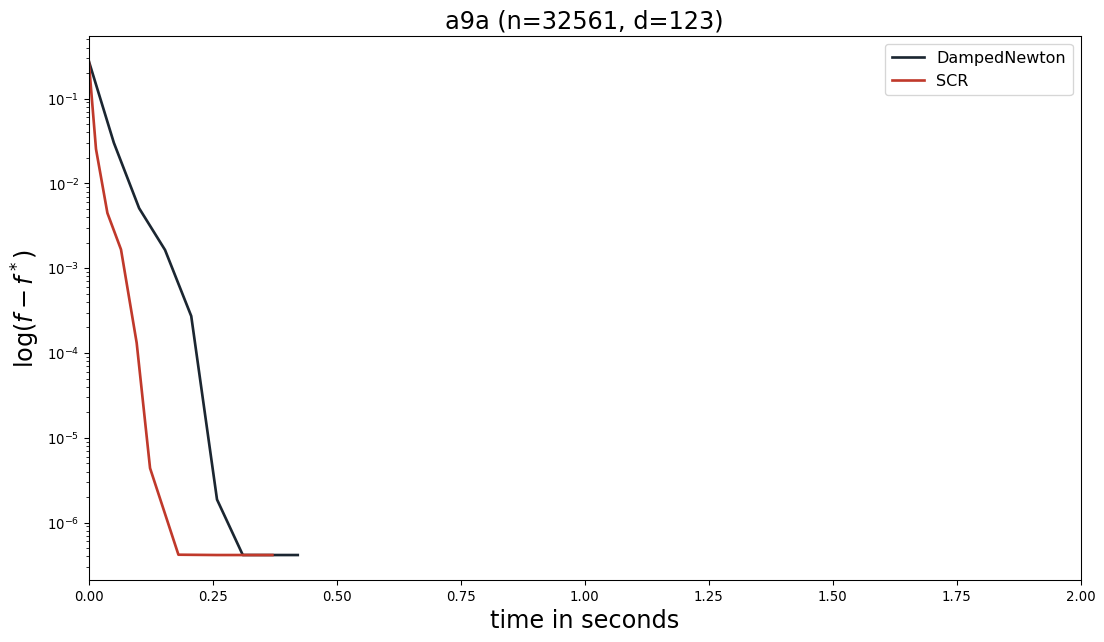

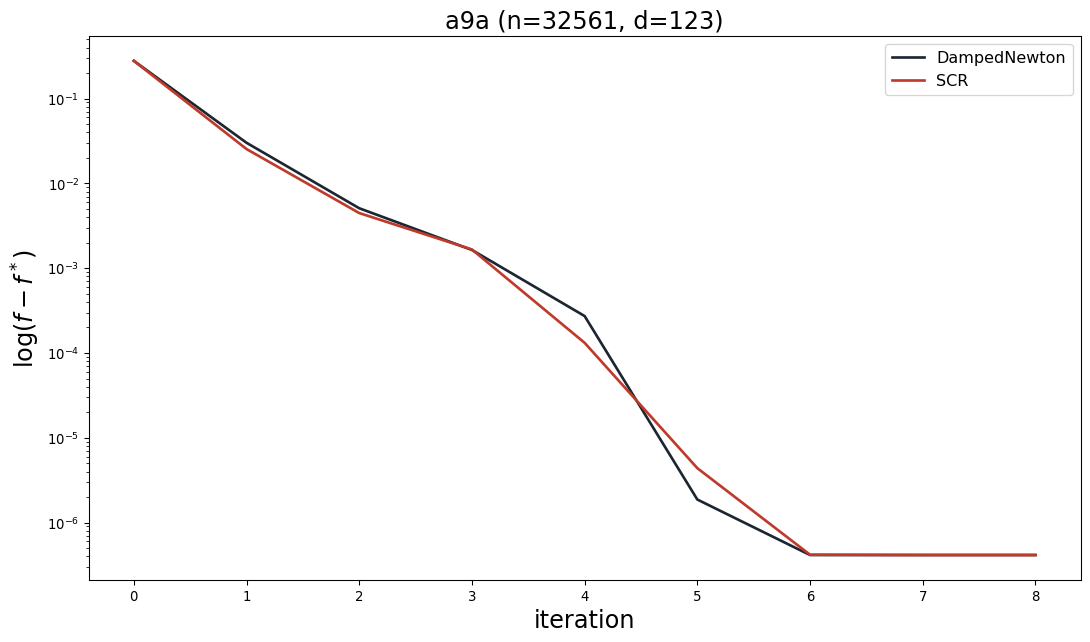

In [83]:
%matplotlib inline
show_plots(x_limits_time=(0,2))